# Using neural nets to solve an optimal control problem: A simple example
#### by [Mahdi Ebrahimi Kahou](https://sites.google.com/site/mahdiebrahimikahou/)

## The problem 
Consider the following problem (From Recursive Macroeconomic Theory by Lars Ljungqvist and Tom Sargent, 3rd edition, Exercise 5.11) 

Here I change the parameters (I like normalizing things)

A price-taking firm is trying to solve an investment problem with adjustment cost as follows:

$\max_{u_t}  \sum_{t=0}^\infty \beta^t\big[(\alpha_0 - \alpha_1 Y_t)y_t-\frac{\gamma}{2}u_t^2\big]$

$s.t.~ Y_{t+1} = h_0 + h_1 Y_t $

$s.t.~ y_{t+1} = y_t+u_t$

$y_0,Y_0~\text{Given}$

This problem can be written in a Linear-Quadratic(LQ) form :

$\max_{u_t} - \sum_{t=0}^\infty \beta^t \big[\vec{x}_t^\top R \vec{x}_t + u_t Q u_t\big]$

$s.t.~\vec{x}_{t+1} = A \vec{x}_t + B u_t$


Where 

$\vec{x}_t \equiv \begin{bmatrix}1\\y_t\\Y_t\end{bmatrix}~$, $R \equiv \begin{bmatrix}0 & -\frac{\alpha_0}{2} & 0 \\ -\frac{\alpha_0}{2} & 0 & \frac{\alpha_1}{2}\\ 0 & \frac{\alpha_1}{2} & 0 \end{bmatrix}~$, $~Q \equiv \frac{\gamma}{2}$

$A \equiv \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0 \\ h_0 & 0 & h_1 \end{bmatrix}~$, $B \equiv \begin{bmatrix} 0 \\ 1 \\0  \end{bmatrix}$

Now let's solve this via Algebraic Riccati Equation to get the anlaytical solution

## Exact Solution (semi-analytical)

In [1]:
import quantecon as qe
import quantecon.lqcontrol as LQ
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot


In [2]:
class Exact_sol:
    def __init__(self,
                 beta = 0.95,
                 alpha_0 = 1.0,
                 alpha_1 = 2.0,
                 gamma = 90.0,
                 h_0 =  0.03,
                 h_1 = 0.94,
                 time = 63,
                 y_0 = 0.1,
                 Y_0 = 0.2
                ):
        
        self.beta = beta
        self.alpha_0 = alpha_0
        self.alpha_1 = alpha_1
        self.gamma = gamma
        self.h_0 = h_0
        self.h_1= h_1
        self.time = time
        self.y_0 = y_0
        self.Y_0 = Y_0
        
        self.R = np.matrix([[0.0,-self.alpha_0/2 , 0.0],[-self.alpha_0/2, 0.0, self.alpha_1/2],[0.0,self.alpha_1/2, 0.0]])
        self.Q = self.gamma/2
        self.A = np.matrix([[1.0,0.0,0.0],[0.0,1.0,0.0],[self.h_0,0.0, self.h_1]])
        self.B = np.matrix([[0.0],[1.0],[0.0]])
        
        self.lq = LQ.LQ(self.Q, self.R, self.A, self.B, beta=self.beta)
        self.P, self.F, self.d = self.lq.stationary_values()
        
        self.x_0 = np.matrix([[1.0],[self.y_0],[self.Y_0]])
        self.dynamics = self.lq.compute_sequence(self.x_0,self.time)
        
        self.ones = self.dynamics[0][0].reshape([self.time+1,1])
        self.y_t = self.dynamics[0][1].reshape([self.time+1,1])
        self.Y_t = self.dynamics[0][2].reshape([self.time+1,1])
        
        self.x_t = np.concatenate((self.ones,self.y_t,self.Y_t), axis=1).T
        
        self.u_t = -np.dot(self.F,self.x_t).T
        

In [3]:
fontsize= 16
ticksize = 14
figsize = (6, 3.5)
params = {"text.usetex": True,
    'font.family':'serif',
    "figure.figsize":figsize, 
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize, 
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params)   

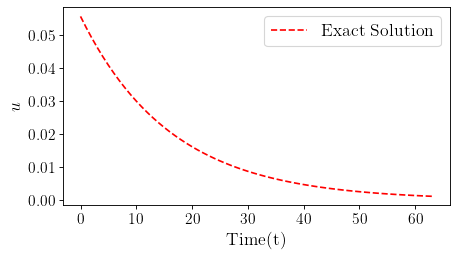

In [4]:
plt.plot(Exact_sol().u_t, "--", color='r', label= r"Exact Solution")
plt.ylabel(r"$u$")
plt.xlabel(r"Time(t)")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

#### Voila you have half of the picture
Let's get the other half. Before that lets do the last piece of the theory. I use the Euler equation here.

## Euler Equation
The Euler equation can be written as:

$\gamma u_t = \beta \big[\gamma u_{t+1}+(\alpha_0 -\alpha_1 Y_{t+1})\big]$

where

$Y_{t+1} = h_0 + h_1 Y_t$

#### Recursive form:
$\gamma u(Y) = \beta \big[\gamma u(Y')+(\alpha_0 -\alpha_1 Y')\big]$

where

$Y' = h_0 + h_1 Y$

#### Note:
Here I wrote $u(Y)$, technically I should write $u(y,Y)$. However, if you stare at the Euler equation long enough, you see there is no $y$ in it, so it must be that $u$ does not depend on $y$. It is easy to check that also numerically. 

The soultion to the liear quadratic problem can be written as:

$u(\vec{x}) = - F . x = - (f_0 + f_1y + f_2 Y) $. So lets what the second element of $F$ is

In [5]:
print("The second element of F is ", Exact_sol().F[0,1])

The second element of F is  6.328271240363392e-17


## Solving the Problem with a Deep Neural Net (DNN)

Here we are looking a function $u$ (a neural net here) that solves the Euler equation. By solving I mean a function that minizes $L_2$ norm of the Euler residuals

$\varepsilon (Y;u)^2 \equiv \bigg(\gamma u(Y)-\beta\big[\gamma u\big(Y'(Y)\big)+ \big(\alpha_0 -\alpha_1 Y'(Y)\big)\big]\bigg)^2 $

over some points of interest in state space $\Gamma(Y) \subset \mathbb{R}$

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### Defining the neural net

In [7]:
class NN(nn.Module):
    def __init__(self, 
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        torch.manual_seed(1234)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.ReLU())  
            
        module.append(nn.Linear(self.dim_hidden,1))
        
        self.u = nn.Sequential(*module)


    def forward(self, x):
        u_out = self.u(x)
        return  u_out

#### Preparing the data for training

In [8]:
class Data:
    def __init__(self,
                 beta = 0.95,
                 alpha_0 = 1.0,
                 alpha_1 = 2.0,
                 gamma = 90.0,
                 h_0 =  0.03,
                 h_1 = 0.94,
                 time = 64,
                 Y_0 = 0.2,
                 batch_size = 4
                ):
        self.beta = beta
        self.alpha_0 = alpha_0
        self.alpha_1 = alpha_1
        self.gamma = gamma
        self.h_0 = h_0
        self.h_1= h_1
        self.time = time
        self.Y_0 = Y_0
        self.batch_size = batch_size
        
        self.Y_t = torch.zeros([self.time])
        self.Y_t[0] = self.Y_0
        for t in range(self.time-1):
            self.Y_t[t+1] = self.h_0 + self.h_1*self.Y_t[t]
            
        self.Y_prime_t = self.h_0 + self.h_1*self.Y_t
        
        self.train_data = torch.stack((self.Y_t,self.Y_prime_t),1)


#### Preparing the data loader 
This is needed because I am going to use [Stochastic Gradient Descent(SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) optimization. If you are going to use gradient descent, you dont need this.

In [9]:
from torch.utils.data import Dataset, DataLoader

In [10]:
class Data_loader(Dataset):
    
    def __init__(self,data):
        self.data = data
        self.Y = self.data[:,[0]]
        self.Y_prime = self.data[:,1:]
        self.n_samples = self.data.shape[0]

    def __getitem__(self,index):
            return self.Y[index], self.Y_prime[index] # order: Y first, then Y_prime 
        
    def __len__(self):
        return self.n_samples

In [11]:
data_set = Data().train_data
data_label = Data_loader(data = data_set)
batch_size = Data().batch_size
train = DataLoader(dataset = data_label, batch_size = batch_size, shuffle = True)


#### Defining the parameters

In [12]:
α_0 = Data().alpha_0
α_1 = Data().alpha_1
γ = Data().gamma
β = Data().beta

In [13]:
max_epochs = 1001

#### Initializing the neural net and setting up the optimizer

In [14]:
u_hat = NN()
learning_rate = 1e-2

optimizer = torch.optim.Adam(u_hat.parameters(), lr=learning_rate, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 20, threshold = 0.0 , cooldown =  1 )

#### Training loop

In [15]:
for epoch in range(max_epochs):
    for index, (Y,Y_prime) in enumerate(train):
        
        euler_res = γ*u_hat(Y) - β*( γ*u_hat(Y_prime) + α_0 - α_1* Y_prime )
        loss = euler_res.pow(2).mean()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
        #print("epoch:",",",epoch,',',"{:.2e}".format(loss.item()),',',"{:.2e}".format(get_lr(optimizer))) 
        print("epoch:",epoch, ",","MSE Euler Residuals:","{:.2e}".format(loss.item()))    

        

epoch: 0 , MSE Euler Residuals: 8.15e-02
epoch: 100 , MSE Euler Residuals: 6.81e-05
epoch: 200 , MSE Euler Residuals: 1.01e-08
epoch: 300 , MSE Euler Residuals: 1.14e-12
epoch: 400 , MSE Euler Residuals: 1.59e-11
epoch: 500 , MSE Euler Residuals: 2.15e-10
epoch: 600 , MSE Euler Residuals: 2.08e-10
epoch: 700 , MSE Euler Residuals: 1.35e-11
epoch: 800 , MSE Euler Residuals: 1.11e-11
epoch: 900 , MSE Euler Residuals: 7.63e-11
epoch: 1000 , MSE Euler Residuals: 8.97e-13


#### Plotting the results

In [16]:
u_hat.eval()
Y_t = Data().train_data[:,[0]]

approx_sol = u_hat(Y_t).detach()

exact_sol = Exact_sol().u_t

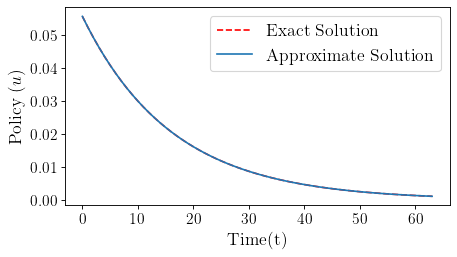

In [17]:
plt.plot(exact_sol, "--", color='r', label= r"Exact Solution")
plt.plot(approx_sol,label= r"Approximate Solution" )
plt.ylabel(r"Policy $(u)$")
plt.xlabel(r"Time(t)")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("exact_vs_approx.pdf")
plt.show()

#### Now you have the full picture
The reason you dont see the exact solution is because the approximate solution completely covers exact solution. 

So let's look at the difference between the exact and approximate soloution

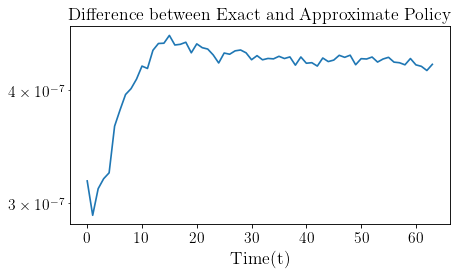

In [18]:
err = approx_sol - exact_sol
plt.plot(err)
plt.xlabel(r"Time(t)")
pyplot.yscale('log')
plt.tight_layout()
plt.title(r"Difference between Exact and Approximate Policy")
plt.savefig("err_exact_approx.pdf")
plt.show()